In [1]:
def generate_stay_and_note_timing_table(relevant_subjects, stays, notes):
    
    # filter for useful notes and stays data
    def _filter_notes_and_stays(relevant_subjects, stays, notes):
        '''
        Get all NOTE_ID, SUBJECT_ID, and charttime from overall note data.
        Get all SUBJECT_ID, ICUSTAY_ID, and INTIME from overall stay data.
        Returns both dataframes.

        Args:
            relevant_subjects: all subjects in cohort (train or test), 
                drawn from time series data
            stays: icustay data -- from MIMIC IV 
            notes: note data -- from MIMIC IV Note (Radiology or Discharge)
        '''
        relevant_notes = notes[notes['SUBJECT_ID'].isin(relevant_subjects)]
        relevant_stays = stays[stays['SUBJECT_ID'].isin(relevant_subjects)]

        relevant_notes = relevant_notes[['SUBJECT_ID', 'NOTE_ID', 'charttime']]
        relevant_stays = relevant_stays[['SUBJECT_ID', 'ICUSTAY_ID', 'INTIME']]
        return (relevant_notes, relevant_stays)

    # concatenate notes and stays, grouping by subject and sorting by DATETIME
    def _concat_and_sort_table(relevant_notes, relevant_stays):
        '''
        Time series concatentation and alignment of notes and stays.

        args:
            relevant notes: df with cols ['SUBJECT_ID', 'NOTE_ID', 'charttime']
            relevant_stays: df with cols ['SUBJECT_ID', 'ICUSTAY_ID', 'INTIME']

        returns:
            stay_note_timing: df with cols ['SUBJECT_ID', 'DATETIME', 'NOTE_ID', 'ICUSTAY_ID']
        '''
        stay_note_timing = pd.concat([relevant_notes, relevant_stays]).sort_values(by='SUBJECT_ID')
        stay_note_timing['DATETIME'] = stay_note_timing['INTIME'].combine_first(stay_note_timing['charttime'])
        stay_note_timing.drop(['charttime'], axis=1, inplace=True)
        stay_note_timing = stay_note_timing.groupby('SUBJECT_ID', group_keys=True).apply(lambda x: x.sort_values('DATETIME'))
        stay_note_timing.reset_index(drop=True, inplace=True)
        stay_note_timing.infer_objects()
        return stay_note_timing
    
    def _fillna_icustay_by_subject(stay_note_timing_by_subject):
        '''
        inputs:
            stay_note_timing_by_stay: a subset of stay_note_timing for a single subject

        for all rows with notes, fill forwards with the most recent ICUSTAY_ID, filling backwards if note predates ICUSTAY.
        '''
        stay_note_timing_by_subject['ICUSTAY_ID'].fillna(method='ffill', inplace=True) 
        stay_note_timing_by_subject['ICUSTAY_ID'].fillna(method='bfill', inplace=True)   
        return stay_note_timing_by_subject

    
    def _fillna_intime_by_stay(stay_note_timing_by_stay):
        '''
        inputs:
            stay_note_timing_by_stay: a subset of stay_note_timing for a single stay

        for all rows with notes, fill forwards with the most recent INTIME, filling backwards if note predates ICUSTAY.
        '''
        stay_note_timing_by_stay['INTIME'].fillna(method='ffill', inplace=True)
        stay_note_timing_by_stay['INTIME'].fillna(method='bfill', inplace=True)
        return stay_note_timing_by_stay

    relevant_notes, relevant_stays = _filter_notes_and_stays(relevant_subjects = relevant_subjects, stays = stays, notes = notes)
    stay_note_timing = _concat_and_sort_table(relevant_notes, relevant_stays)
    stay_note_timing = stay_note_timing.groupby('SUBJECT_ID', group_keys=True).apply(_fillna_icustay_by_subject)
    stay_note_timing = stay_note_timing.groupby('ICUSTAY_ID', group_keys=True).apply(_fillna_intime_by_stay)
    
    stay_note_timing['DATETIME'] = pd.to_datetime(stay_note_timing['DATETIME'])
    stay_note_timing['INTIME'] = pd.to_datetime(stay_note_timing['INTIME'])
    stay_note_timing = stay_note_timing.convert_dtypes(infer_objects=True)

    stay_note_timing.dropna(inplace=True) # remove 'stay' rows which don't contain notes
    return stay_note_timing

In [86]:
def _insert_note_data_by_stay(mimic_iv_train_per_stay, how = "recent"):
    ''' FIXME this needs to get ALL NOTES, not just most recent note.
    for time series data for a single icustay, populate most recent note id, returning None if there are no previous notes

    args:
        mimic_iv_train_per_stay: a dataframe containing time series data for a single icu stay
        how: from ["recent", "all"] determines how to insert note data. 
            if how = "recent", gets most recent note.
            if how = "all", gets all notes and stores them as a list.
    
    returns:
        time series data with NOTE_ID in new column 'NOTE_ID'
    '''
    def _populate_recent_note_id(row):
        stay_note_timing_for_subject = stay_note_timing[stay_note_timing['SUBJECT_ID'] == row['SUBJECT_ID']]
        prev_notes = stay_note_timing_for_subject[stay_note_timing_for_subject['DATETIME'] < row['t_start_DT']]['NOTE_ID']
        
        if prev_notes.empty:
            row['NOTE_ID'] = None
            return row
        row['NOTE_ID'] = prev_notes.iloc[-1]
        return row

    def _populate_all_note_ids(row):
        stay_note_timing_for_subject = stay_note_timing[stay_note_timing['SUBJECT_ID'] == row['SUBJECT_ID']]
        prev_notes = stay_note_timing_for_subject[stay_note_timing_for_subject['DATETIME'] < row['t_start_DT']]['NOTE_ID']
        row['NOTE_ID'] = prev_notes.tolist()
        return row
    
    if how == "recent":
        mimic_iv_train_per_stay = mimic_iv_train_per_stay.apply(_populate_recent_note_id, axis=1)
    elif how == "all":
        mimic_iv_train_per_stay = mimic_iv_train_per_stay.apply(_populate_all_note_ids, axis=1)
    return mimic_iv_train_per_stay

def _populate_time_since_note(row):
    if isinstance(row['NOTE_ID'], list):
        if row['NOTE_ID'] == []:
            row['time_since_note'] = None
        else:
            charttime = stay_note_timing[stay_note_timing['NOTE_ID'] == row['NOTE_ID'][-1]]['DATETIME']
            time_since_note = (row['t_start_DT'] - charttime.iloc[0]).total_seconds()/3600
            row['time_since_note'] = time_since_note
    else:
        if pd.isna(row['NOTE_ID']):
            row['time_since_note'] = None
        else:
            charttime = stay_note_timing[stay_note_timing['NOTE_ID'] == row['NOTE_ID']]['DATETIME']
            time_since_note = (row['t_start_DT'] - charttime.iloc[0]).total_seconds()/3600
            row['time_since_note'] = time_since_note
    return row

In [76]:
# a = [[]]
# b = [[1]]
# c = [1]
# d = []
# z = pd.DataFrame([a,b,c, d])
# # z.iloc[0].any()
# # z.iloc[1].any()
# # z.iloc[2].any()
# z
# z.iloc[3].any()

False

In [4]:
# stay_note_timing_for_subject = stay_note_timing[stay_note_timing['SUBJECT_ID'] == 10000032]
# prev_notes = stay_note_timing_for_subject[stay_note_timing_for_subject['DATETIME'] < '2180-07-23 14:00:00.000000000']
# prev_notes = prev_notes

# # if prev_notes.empty:
# #     row['NOTE_ID'] = None
# #     return row
# print('prev_notes:', prev_notes)

In [5]:
# prev_notes.NOTE_ID

In [52]:

import pandas as pd
import argparse

# parser = argparse.ArgumentParser()
# parser.add_argument('--test', action='store_true', help='enable testing mode')
# parser.add_argument('--note-type', dest = 'note_type', help='which notes, radiology or discharge?')
# args = parser.parse_args()

args = argparse.Namespace()
args.test = True
args.note_type = 'radiology'
# args.note_type = 'discharge'

testing = args.test
print(f"testing = {testing}")
assert(args.note_type == 'radiology' or args.note_type == 'discharge')

trainpath = '/home/ugrads/a/aa_ron_su/BoXHED_Fuse/JSS_SUBMISSION_NEW/data/till_end_mimic_iv_extra_features_train.csv' #mimic_iv_train.csv'
testpath = '/home/ugrads/a/aa_ron_su/BoXHED_Fuse/JSS_SUBMISSION_NEW/data/till_end_mimic_iv_extra_features_test.csv' #mimic_iv_test.csv'

out_trainpath = f'/home/ugrads/a/aa_ron_su/BoXHED_Fuse/JSS_SUBMISSION_NEW/data/till_end_mimic_iv_extra_features_train_NOTE_{args.note_type[:3]}.csv'# (rad for radiology, dis for discharge)
out_testpath =  f'/home/ugrads/a/aa_ron_su/BoXHED_Fuse/JSS_SUBMISSION_NEW/data/till_end_mimic_iv_extra_features_test_NOTE_{args.note_type[:3]}.csv'

mimic_iv_train = pd.read_csv(trainpath)
mimic_iv_test = pd.read_csv(testpath)
print(f"read from {trainpath}")
print(f"read from {testpath}")

mimic_iv_train.rename(columns={'Icustay':'ICUSTAY_ID', 'subject':'SUBJECT_ID'}, inplace=True)
mimic_iv_test.rename(columns={'Icustay':'ICUSTAY_ID', 'subject':'SUBJECT_ID'}, inplace=True)

print(f"{trainpath} has {len(mimic_iv_train['ICUSTAY_ID'].unique())} unique Icustays")
print(f"{testpath} has {len(mimic_iv_test['ICUSTAY_ID'].unique())} unique Icustays")

if testing:
    mimic_iv_train = mimic_iv_train.iloc[:2000]
    mimic_iv_test = mimic_iv_test.iloc[:2000]

all_stays = pd.read_csv('/home/ugrads/a/aa_ron_su/BoXHED_Fuse/JSS_SUBMISSION_NEW/tmp/all_stays.csv')

discharge = pd.read_csv('/data/datasets/mimiciv_notes/physionet.org/files/mimic-iv-note/2.2/note/discharge.csv')
discharge.rename(columns={'subject_id':'SUBJECT_ID'}, inplace = True)
discharge.rename(columns={'note_id':'NOTE_ID'}, inplace = True)

radiology = pd.read_csv('/data/datasets/mimiciv_notes/physionet.org/files/mimic-iv-note/2.2/note/radiology.csv')
radiology.rename(columns={'subject_id':'SUBJECT_ID'}, inplace = True)
radiology.rename(columns={'note_id':'NOTE_ID'}, inplace = True)

notes_to_use = radiology if args.note_type == 'radiology' else discharge


from tqdm.auto import tqdm
tqdm.pandas()
from time import time

testing = True
read from /home/ugrads/a/aa_ron_su/BoXHED_Fuse/JSS_SUBMISSION_NEW/data/till_end_mimic_iv_extra_features_train.csv
read from /home/ugrads/a/aa_ron_su/BoXHED_Fuse/JSS_SUBMISSION_NEW/data/till_end_mimic_iv_extra_features_test.csv
/home/ugrads/a/aa_ron_su/BoXHED_Fuse/JSS_SUBMISSION_NEW/data/till_end_mimic_iv_extra_features_train.csv has 30716 unique Icustays
/home/ugrads/a/aa_ron_su/BoXHED_Fuse/JSS_SUBMISSION_NEW/data/till_end_mimic_iv_extra_features_test.csv has 5352 unique Icustays


In [53]:
import pandas as pd
from time import time
# FIXME DELETEME
df_NOTES = []

tstart = time()

df = mimic_iv_train

relevant_subjects = set(df["SUBJECT_ID"])
print(f"time {time() - tstart}: generating stay_note_timing_table")
stay_note_timing = generate_stay_and_note_timing_table(relevant_subjects, all_stays, notes_to_use)

time 0.0007414817810058594: generating stay_note_timing_table


In [10]:
# len(stay_note_timing),len(stay_note_timing.NOTE_ID.unique()), sum(stay_note_timing.NOTE_ID.isna()), len(stay_note_timing.ICUSTAY_ID.unique())

In [10]:
# len(stay_note_timing_OLD),len(stay_note_timing_OLD.NOTE_ID.unique()), sum(stay_note_timing_OLD.NOTE_ID.isna()), len(stay_note_timing_OLD.ICUSTAY_ID.unique())

In [11]:
# stay_note_timing_OLD[~stay_note_timing_OLD.ICUSTAY_ID.isin(stay_note_timing.ICUSTAY_ID)]

In [54]:
# from functools import partial
# df_NOTES = []

# tstart = time()

# df = mimic_iv_train

# # relevant_subjects = set(df["SUBJECT_ID"])
# # print(f"time {time() - tstart}: generating stay_note_timing_table")
# # stay_note_timing = generate_stay_and_note_timing_table(relevant_subjects, all_stays, notes_to_use)

# # df_tmp is populated with useful columns for our note merge.
# df_tmp = df.copy()
# df_tmp.rename(columns={'Icustay': 'ICUSTAY_ID'}, inplace = True) 
# print(f"time {time() - tstart}: merging INTIME on ICUSTAY_ID")
# df_tmp = df_tmp.merge(all_stays[['ICUSTAY_ID', 'INTIME']], how = 'left', on ='ICUSTAY_ID') # merge with all_stays['intime'] on Icustay

# df_tmp['INTIME'] = pd.to_datetime(df_tmp['INTIME'])
# df_tmp['t_start_DT'] = df_tmp['INTIME'] + pd.to_timedelta(df_tmp['t_start'], unit='h')

# print(f"time {time() - tstart}: inserting note data by stay")
# df_NOTE_OLD = df_tmp.groupby('ICUSTAY_ID', group_keys=True).progress_apply(partial(_insert_note_data_by_stay, how="recent"))

In [93]:
from functools import partial
df_NOTES = []

tstart = time()

df = mimic_iv_train

# relevant_subjects = set(df["SUBJECT_ID"])
# print(f"time {time() - tstart}: generating stay_note_timing_table")
# stay_note_timing = generate_stay_and_note_timing_table(relevant_subjects, all_stays, notes_to_use)

# df_tmp is populated with useful columns for our note merge.
df_tmp = df.copy()
df_tmp.rename(columns={'Icustay': 'ICUSTAY_ID'}, inplace = True) 
print(f"time {time() - tstart}: merging INTIME on ICUSTAY_ID")
df_tmp = df_tmp.merge(all_stays[['ICUSTAY_ID', 'INTIME']], how = 'left', on ='ICUSTAY_ID') # merge with all_stays['intime'] on Icustay

df_tmp['INTIME'] = pd.to_datetime(df_tmp['INTIME'])
df_tmp['t_start_DT'] = df_tmp['INTIME'] + pd.to_timedelta(df_tmp['t_start'], unit='h')

print(f"time {time() - tstart}: inserting note data by stay")
df_NOTE = df_tmp.groupby('ICUSTAY_ID', group_keys=True).progress_apply(partial(_insert_note_data_by_stay, how = "all"))

time 0.002224445343017578: merging INTIME on ICUSTAY_ID
time 0.03413081169128418: inserting note data by stay


  0%|          | 0/16 [00:00<?, ?it/s]

In [35]:
lengths = df_NOTE.NOTE_ID.apply(lambda x: len(x))

In [36]:
df_NOTE_LENGTHS = df_NOTE.copy()
df_NOTE_LENGTHS['noteseq_len'] = lengths

In [37]:
lengths.head(100)

ICUSTAY_ID      
30676350.0  1362    45
            1363    45
            1364    45
            1365    45
            1366    45
                    ..
31090461.0  376     27
            377     27
            378     27
            379     27
            380     27
Name: NOTE_ID, Length: 100, dtype: int64

In [38]:
n_notes_start_stay = df_NOTE_LENGTHS.groupby(level=0).noteseq_len.first()

In [39]:
n_notes_end_stay = df_NOTE_LENGTHS.groupby(level=0).noteseq_len.last()

In [40]:
new_notes_per_stay = n_notes_end_stay - n_notes_start_stay

In [41]:
df_NOTE_LENGTHS.columns

Index(['SUBJECT_ID', 'ICUSTAY_ID', 't_start', 't_end', 'Capillary refill rate',
       'Diastolic blood pressure', 'Fraction inspired oxygen',
       'Glascow coma scale total', 'Glucose', 'Heart Rate',
       ...
       'O2 Consumption', 'Respiratory Quotient', '#past_IVs',
       't_from_last_IV_t_start', 't_from_last_IV_t_end', 'delta', 'INTIME',
       't_start_DT', 'NOTE_ID', 'noteseq_len'],
      dtype='object', length=106)

In [42]:
df_NOTE_LENGTHS_out = df_NOTE_LENGTHS[['SUBJECT_ID', 'ICUSTAY_ID', 't_start', 't_end', 'delta', 'INTIME',
       't_start_DT', 'NOTE_ID', 'noteseq_len']]

In [44]:
# df_NOTE_LENGTHS_out.to_csv('../views/note_lengths.dis.view.csv')
df_NOTE_LENGTHS_out.to_csv('../views/note_lengths.rad.view.csv')

In [46]:
df_NOTE_LENGTHS_out.columns

Index(['SUBJECT_ID', 'ICUSTAY_ID', 't_start', 't_end', 'delta', 'INTIME',
       't_start_DT', 'NOTE_ID', 'noteseq_len'],
      dtype='object')

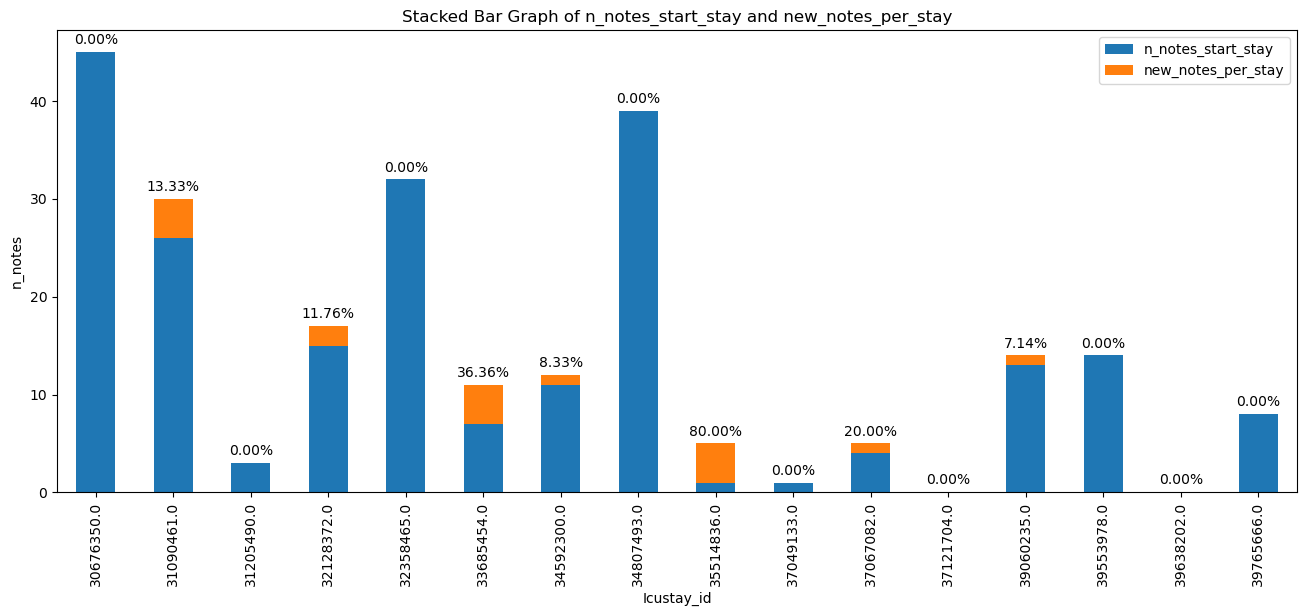

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    'n_notes_start_stay': n_notes_start_stay,
    'new_notes_per_stay': new_notes_per_stay
}

# Create a DataFrame from the data
df = pd.DataFrame(data)

# Plot a stacked bar graph
ax = df.plot(kind='bar', stacked=True, figsize=(16, 6))

# Customize the plot
plt.title('Stacked Bar Graph of n_notes_start_stay and new_notes_per_stay')
plt.xlabel('Icustay_id')  # Replace with your category labels
plt.ylabel('n_notes')
plt.legend()


prop_new = (new_notes_per_stay / n_notes_end_stay).fillna(0).tolist()

# Add prop_new as text labels above each bar
for i, (n_notes_start, new_notes) in enumerate(zip(df['n_notes_start_stay'], df['new_notes_per_stay'])):
    total_notes = n_notes_start + new_notes
    x = i  # x-coordinate for the text label
    y = total_notes + 0.5  # y-coordinate for the text label
    plt.text(x, y, f'{100 * prop_new[i]:.2f}%', ha='center', va='bottom', rotation=0)

# Show the plot
plt.show()


In [95]:
print(f"time {time() - tstart}: populating time since note")
df_NOTE = df_NOTE.progress_apply(_populate_time_since_note, axis=1)

# print(f"time {time() - tstart}: merging text on NOTE_ID")
# df_NOTE = df_NOTE.merge(notes_to_use[['NOTE_ID', 'text']], how = 'left', on = 'NOTE_ID')

df_NOTES.append(df_NOTE)

mimic_iv_train_NOTE_OLD = df_NOTES[0]

# mimic_iv_train_NOTE.to_csv(out_trainpath, index=False)
# mimic_iv_test_NOTE.to_csv(out_testpath, index=False)

# print(f"wrote to {out_trainpath}")
# print(f"wrote to {out_testpath}")

# print(f"{out_trainpath} has {len(mimic_iv_train_NOTE_OLD['NOTE_ID'].unique())} unique NOTE_IDs")

time 39.874725103378296: populating time since note


  0%|          | 0/2000 [00:00<?, ?it/s]

In [91]:
'''
insert note data by stay, but with ALL notes
'''
df_NOTES = []

tstart = time()

df = mimic_iv_train

# relevant_subjects = set(df["SUBJECT_ID"])
# print(f"time {time() - tstart}: generating stay_note_timing_table")
# stay_note_timing = generate_stay_and_note_timing_table(relevant_subjects, all_stays, notes_to_use)

# df_tmp is populated with useful columns for our note merge.
df_tmp = df.copy()
df_tmp.rename(columns={'Icustay': 'ICUSTAY_ID'}, inplace = True) 
print(f"time {time() - tstart}: merging INTIME on ICUSTAY_ID")
df_tmp = df_tmp.merge(all_stays[['ICUSTAY_ID', 'INTIME']], how = 'left', on ='ICUSTAY_ID') # merge with all_stays['intime'] on Icustay

df_tmp['INTIME'] = pd.to_datetime(df_tmp['INTIME'])
df_tmp['t_start_DT'] = df_tmp['INTIME'] + pd.to_timedelta(df_tmp['t_start'], unit='h')

print(f"time {time() - tstart}: inserting note data by stay")
df_NOTE = df_tmp.groupby('ICUSTAY_ID', group_keys=True).progress_apply(_insert_note_data_by_stay)

print(f"time {time() - tstart}: populating time since note")
df_NOTE = df_NOTE.progress_apply(_populate_time_since_note, axis=1)

# print(f"time {time() - tstart}: merging text on NOTE_ID")
# df_NOTE = df_NOTE.merge(notes_to_use[['NOTE_ID', 'text']], how = 'left', on = 'NOTE_ID')

df_NOTES.append(df_NOTE)

mimic_iv_train_NOTE_OLD = df_NOTES[0]

# mimic_iv_train_NOTE.to_csv(out_trainpath, index=False)
# mimic_iv_test_NOTE.to_csv(out_testpath, index=False)

# print(f"wrote to {out_trainpath}")
# print(f"wrote to {out_testpath}")

print(f"{out_trainpath} has {len(mimic_iv_train_NOTE_OLD['NOTE_ID'].unique())} unique NOTE_IDs")


time 0.0030701160430908203: merging INTIME on ICUSTAY_ID
time 0.03674793243408203: inserting note data by stay


  0%|          | 0/16 [00:00<?, ?it/s]

time 4.711388111114502: populating time since note


  0%|          | 0/2000 [00:00<?, ?it/s]

/home/ugrads/a/aa_ron_su/BoXHED_Fuse/JSS_SUBMISSION_NEW/data/till_end_mimic_iv_extra_features_train_NOTE_rad.csv has 26 unique NOTE_IDs


In [ ]:
mimic_iv_train.ICUSTAY_ID.nunique()

In [ ]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_rows', 100)
